In [2]:
import os
import openeo
import json
import time
from datetime import datetime, timedelta
import os
import json
import openeo
import datetime

In [3]:
# Conectando ao serviço OpenEO
# Aqui, precisei fazer login no site. Isso me permitiu autenticar
connection = openeo.connect("openeo.dataspace.copernicus.eu")
connection.authenticate_oidc_device(store_refresh_token=True)

# Aqui consigo verificar as informações da conexão (deve me retornar os meus dados de conta)
# connection.describe_account() 

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=DKXU-NNKM 📋 to authenticate.

✅ Authorized successfully

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [4]:
# Crie um arquivo geojson da região de interesse através do QGIS e EXPORTE EM EPSG 4326
# Carregando o arquivo GeoJSON
geojson_path = "./study_area/area_estudo_chl_a.geojson" 
with open(geojson_path) as f:
    geojson = json.load(f)
    
geom = geojson['features'][0]['geometry'] # Extraindo a geometria do GeoJSON

## Verificações

In [5]:
# Para definirmos as coleções que podemos usar
collections = connection.list_collections()
for collection in collections:
    print(collection['id'])

SENTINEL3_OLCI_L1B
SENTINEL3_SLSTR
SENTINEL_5P_L2
COPERNICUS_VEGETATION_PHENOLOGY_PRODUCTIVITY_10M_SEASON1
COPERNICUS_VEGETATION_PHENOLOGY_PRODUCTIVITY_10M_SEASON2
COPERNICUS_PLANT_PHENOLOGY_INDEX
ESA_WORLDCOVER_10M_2020_V1
ESA_WORLDCOVER_10M_2021_V2
COPERNICUS_VEGETATION_INDICES
SENTINEL2_L1C
SENTINEL2_L2A
SENTINEL1_GRD
COPERNICUS_30
LANDSAT8_L2
SENTINEL3_SYN_L2_SYN
SENTINEL3_SLSTR_L2_LST
SENTINEL1_GLOBAL_MOSAICS
SENTINEL3_OLCI_L2_LAND
SENTINEL3_OLCI_L2_WATER
SENTINEL3_SYN_L2_AOD


In [6]:
# Para saber o nome das bandas a extrair
satelite = 'SENTINEL2_L2A' 
collection_details = connection.describe_collection(satelite)

# Lista as bandas disponíveis
bands = [band['name'] for band in collection_details['summaries']['eo:bands']]
print(f"Bandas disponíveis na coleção {satelite}:")
print(bands)

Bandas disponíveis na coleção SENTINEL2_L2A:
['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'WVP', 'AOT', 'SCL', 'sunAzimuthAngles', 'sunZenithAngles', 'viewAzimuthMean', 'viewZenithMean']


## NDCI - Normalized Difference Chlorophyll Index


Abaixo, irei fazer o cálculo para NDCI, porém farei uma máscara com o NDWI (Normalized Difference Water Index) para buscar apenas pixels referentes ao corpo d'água, sem mostrar informações de terra.

In [ ]:
# NDCI - Normalized Difference Chlorophyll Index
print("Gerando dados NDCI")

# Diretório de saída
output_dir = "./NDCI/"
os.makedirs(output_dir, exist_ok=True) 

start_date = datetime.datetime(2024, 12, 10)  # insiro aqui a data do antes
end_date = datetime.datetime(2025, 3, 30) # insiro a data posterior ao evento (ou durante)

wait_time = 5  # segundos entre requisições

current_date = start_date
while current_date <= end_date:
    
    print('Fazendo para a data', current_date)
    try:
        date_str = current_date.strftime("%Y-%m-%d")
        
        # Carregando a coleção para a data específica
        datacube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=geom, 
            temporal_extent=[date_str, date_str],
            bands=["B04", "B05", "B03", "B08"],  # bandas necessárias para cálculo do NDCI e NDWI
            max_cloud_cover=20,  # apliquei um percentual de cobertura de nuvens de 20%
        )

        # Cálculo do NDCI (B05 - B04)/(B05 + B04)
        ndci_cube = (datacube.band("B05") - datacube.band("B04")) / (datacube.band("B05") + datacube.band("B04"))

        # Aqui, vou aplicar o cálculo do NDWI 
        ndwi = (datacube.band("B03") - datacube.band("B08")) / (datacube.band("B03") + datacube.band("B08"))

        water_mask = ndwi < 0 # defino que ele deve buscar apenas valores menores que 0, i.e., onde não há dado para corpos d’água
                
        ndci_water_only = ndci_cube.mask(water_mask) # aqui, aplico a máscara para buscar apenas os dados em que ndwi > 0
        
        # Exportando para GeoTIFF
        output_filename = f"{output_dir}NDCI_{date_str}.tif" 
        ndci_water_only.download(output_filename, format="GTiff")
        
        print(f"NDCI file saved to: {output_filename}")
        
    except Exception as e:
        print(f"Error processing NDCI for {current_date}: {str(e)}")
        
    current_date += timedelta(days=1)
        
    time.sleep(wait_time)

Gerando dados NDCI
Fazendo para a data 2025-02-19 00:00:00
Error processing NDCI for 2025-02-19 00:00:00: [400] NoDataAvailable: There is no data available for the given extents. Could not find data for your load_collection request with catalog ID "Sentinel2". The catalog query had correlation ID "r-2505052135004aaa8d2f3ac93ed89e3c" and returned 0 results. (ref: r-2505052135004aaa8d2f3ac93ed89e3c)
Fazendo para a data 2025-02-20 00:00:00
NDCI file saved to: ./NDCI/NDCI_2025-02-20.tif
Fazendo para a data 2025-02-21 00:00:00
Error processing NDCI for 2025-02-21 00:00:00: [400] NoDataAvailable: There is no data available for the given extents. Could not find data for your load_collection request with catalog ID "Sentinel2". The catalog query had correlation ID "r-25050521362949809f058c1f1507d807" and returned 0 results. (ref: r-25050521362949809f058c1f1507d807)
Fazendo para a data 2025-02-22 00:00:00
Error processing NDCI for 2025-02-22 00:00:00: [400] NoDataAvailable: There is no data ava

# Gerando os resultados como gif

In [ ]:
import os
import glob
import imageio
import rasterio
import matplotlib.pyplot as plt

# acesso ao diretório com os arquivos NDCI
ndci_dir = "./NDCI/"
tif_files = sorted(glob.glob(f"{ndci_dir}/NDCI_*.tif"))

# lista para armazenar imagens (frames)
frames = []

for tif_path in tif_files: # vou percorrer tif por tif dentro da pasta
    with rasterio.open(tif_path) as src:
        ndci_data = src.read(1)  # lê a banda única

        fig, ax = plt.subplots(figsize=(6, 6)) # dimensões da digura
        im = ax.imshow(ndci_data, cmap='turbo', vmin=-1, vmax=1) # defini os valores máximos e mínimos de NDCI. 
        # seria possível definir um próprio pra cada .tif, mas a título de comparação isso pode não ser muito interessante
        
        ax.set_title(os.path.splitext(os.path.basename(tif_path))[0]) # Aqui, removo o ".tif" do título para manter apenas o NDCI_data
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
        # fraction define a largura relativa da colorbar em relação ao eixo principal
        # pad define o espaçamento entre o eixo do gráfico e a colorbar

        # salvamento de um .png de cada .tif
        temp_img_path = "temp_frame.png"
        plt.savefig(temp_img_path, bbox_inches='tight', pad_inches=0.1) 
        # 'tight'remove espaços em branco desnecessários ao redor da figura
        # mesmo com o ajuste de tight, uso pad_inches para adicionar uma margem (0.1 polegadas)
        plt.close(fig)

        # adiciono as imagens salvas em um só gif 
        image = imageio.v2.imread(temp_img_path) # Esse array representa um frame da animação 
        frames.append(image) # aqui, o append junta todas as imagens
        
gif_path = "NDCI_animation.gif" #salvo o gif na pasta principal
imageio.mimsave(gif_path, frames, duration=1000,loop=0)  # duração entre frames em milisegundos (1000 ms = 1 segundo por frame)
# loop = 0 significa loop infinito para o gif

print(f"GIF salvo em: {gif_path}")

GIF salvo em: NDCI_animation.gif


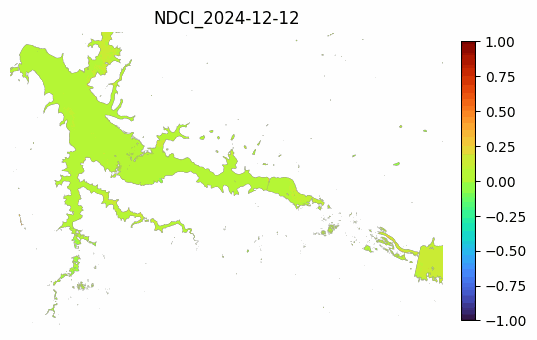

In [9]:
from IPython.display import Image
Image(filename="NDCI_animation.gif")